In [82]:
import numpy as np 
import numpy.ma as ma
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cbook as cbook
import matplotlib.colors as colors
import datetime

from tqdm import tqdm



import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
import glob
import pandas as pd
from astropy.table import Table, vstack

from ResidualUtils import getwavs#, getspecpath



matplotlib.rcParams.update({'xtick.labelsize':18,
                            'ytick.labelsize':18,
                            'axes.titlesize':18,
                            'axes.labelsize':18,
                            'font.size':18,
                            'xtick.top':True,
                            'xtick.minor.visible':True,
                            'ytick.minor.visible':True,
                            'xtick.major.size':4,
                            'xtick.minor.size':2,
                            'ytick.major.size':4,
                            'ytick.minor.size':2,
                            'ytick.right':True,
                            'xtick.direction':'in',
                            'ytick.direction':'in',
                            'font.family':'serif',
                            'text.usetex': False,
                            'pgf.texsystem': 'pdflatex'})
# plt.rcParams['pgf.texsystem'] = 'pdflatex'



flags = ['BADPIX',
'CRPIX',
'SATPIX',
'UNFIXABLE',
'BADDARK',
'BADFLAT',
'BADERR',
'NOSKY',
'LITTROW_GHOST',
'PERSIST_HIGH',
'PERSIST_MED',
'PERSIST_LOW',
'SIG_SKYLINE',
'SIG_TELLURIC']


from TolColors import tol_cmap
rainbow = tol_cmap('rainbow_PuRd')
sunset = tol_cmap('sunset')
iridescent = tol_cmap('iridescent')
for map in [rainbow, sunset, iridescent]:
    map.set_bad('white',1.)

In [3]:
tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits'
stars = Table.read(tabfile, hdu = 1)

CA_fields = ['CA_161-06_btx', 'CA_161-06_btx', 'CA_162-11_btx', 'CA_163-05_btx', 'CA_163-08_btx',
             'CA_165-07_btx', 'CA_165-10_btx']
CA_inds = np.unique(np.concatenate([np.where(stars['FIELD'] == field)[0] for field in CA_fields]))
CA_stars = stars[CA_inds]
CA_clean = CA_stars[np.invert(np.logical_or.reduce([np.isnan(CA_stars['TEFF']), np.isnan(CA_stars['LOGG']), 
                                           np.isnan(CA_stars['M_H'])]))]

select_bitmasked = np.where((np.bitwise_and(stars['ASPCAPFLAG'], 23) == 0) | 
                            (np.bitwise_and(stars['ASPCAPFLAG'], 19) == 0))[0] # perhaps I should also bitmask CA_clean

stars = stars[select_bitmasked]
stars = stars[np.where((stars['TEFF_ERR'] < 600) & (stars['LOGG_ERR'] < 0.5) & (stars['M_H_ERR'] < 0.3))[0]]
stars = stars[np.where(np.abs(stars['GLAT']) > 10)[0]]

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [4]:
meta = Table(fits.open('ResidualsFiles/meta_table.fits')[1].data)

In [5]:
def get_residual(teff, logg, m_h):
    rowselect = np.where(np.logical_and.reduce([teff >= meta['teff_low'], teff < meta['teff_high'], 
                    logg >= meta['logg_low'], logg < meta['logg_high'],
                   m_h >= meta['m_h_low'], m_h < meta['m_h_high']]))[0]
    if len(rowselect) != 1:
#         print('Wrong number of rows')
        return 
    
    
    row = meta[rowselect]
    j, k = (row['j_ind'], row['k_ind'])
    filename = row['fname'].item()
    hdulist = fits.open(filename)
    hdulist = np.array(hdulist)[1:].reshape(30,12)
    hdu = hdulist[j, k].item()
    return hdu

def get_residuals_from_tab(tab):
    residuals = []
    for row in tab:
        hdu = get_residual(row['TEFF'], row['LOGG'], row['M_H'])
        residuals.append(hdu)
    return residuals

def getspecpath(row):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TELESCOPE}/{FIELD}/'
    specname = 'aspcapStar-dr17-{SOURCEID}.fits'
    telescope = np.array(row['TELESCOPE'], dtype = str)
    field = np.array(row['FIELD'], dtype = str)
    sourceid = np.array(row['APOGEE_ID'], dtype = str)
#     length = len(sourceid)
    path = (specdir + specname).format(TELESCOPE = telescope, FIELD = field, SOURCEID = sourceid)
    return path

In [18]:
def create_mask(bitmask, flags = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], skipflags = []):
    # https://www.sdss.org/dr14/algorithms/bitmasks/#APOGEE_PIXMASK
    if type(flags) is not list:
        flags = [flags]
    if type(skipflags) is not list:
        skipflags = [skipflags]

    mask = np.zeros(bitmask.shape)
    for i in flags:
        if i not in skipflags:
            mask[np.bitwise_and(bitmask, 2**i) == 2**i] = 1
    return mask

In [6]:
star_row = CA_clean[0]
star = fits.open(getspecpath(star_row))
spec, model = (star[1].data, star[3].data)
stellar_res = np.divide(spec, model)



medres = get_residual(star_row['TEFF'], star_row['LOGG'], star_row['M_H']).data
res = medres[0, :]



/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


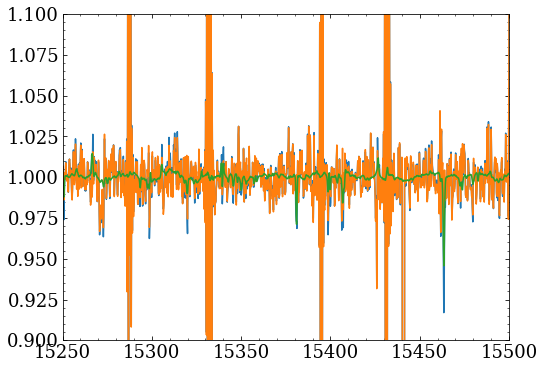

In [7]:
wavs = getwavs()

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(wavs, stellar_res)
ax.plot(wavs, stellar_res / res)
ax.plot(wavs, res)
ax.set_xlim()
ax.set_xlim(15250, 15500)
ax.set_ylim(0.9, 1.1)
plt.show()

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


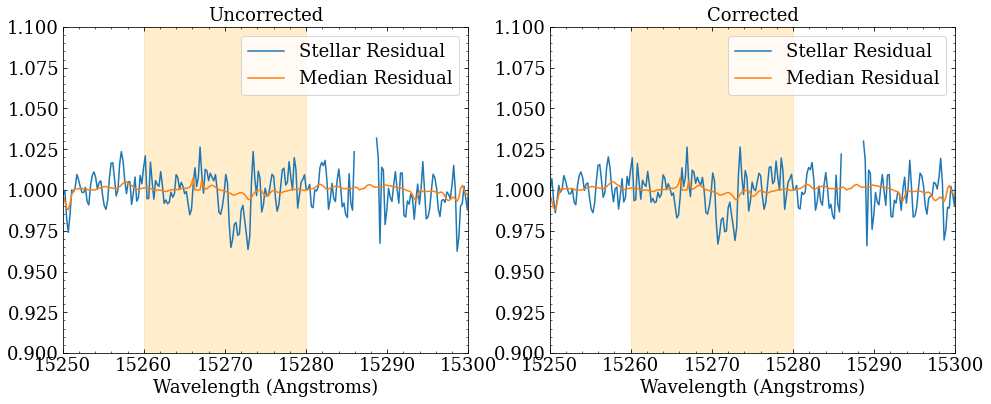

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


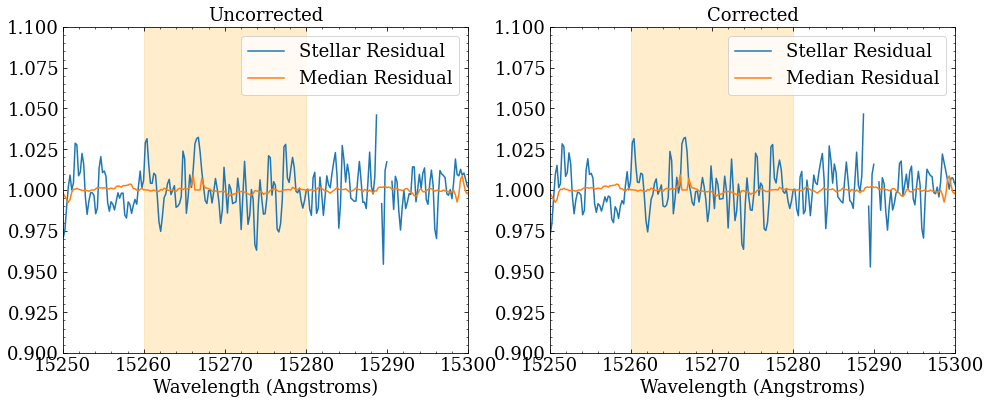

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


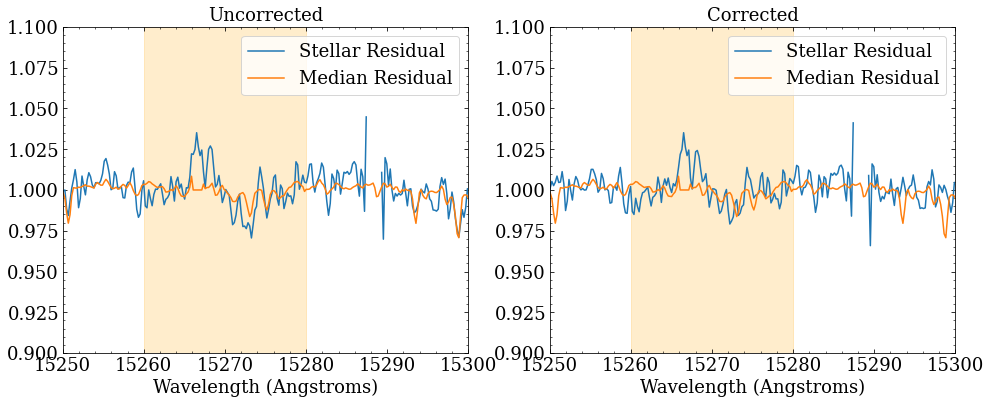

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


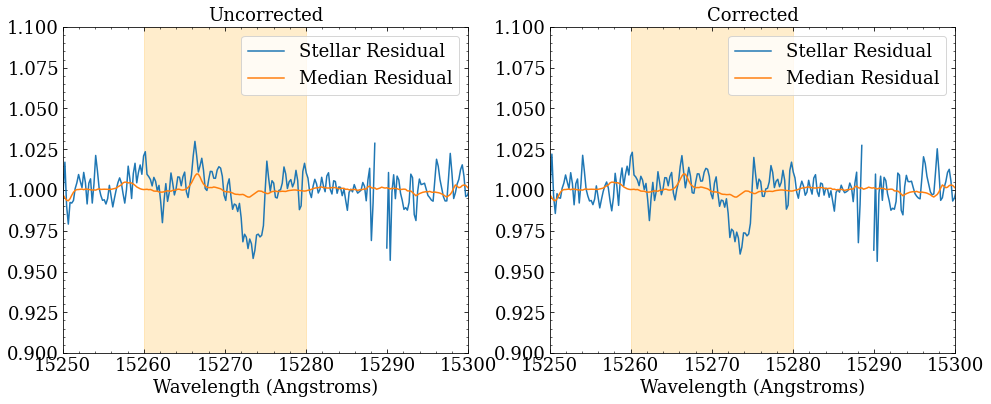

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


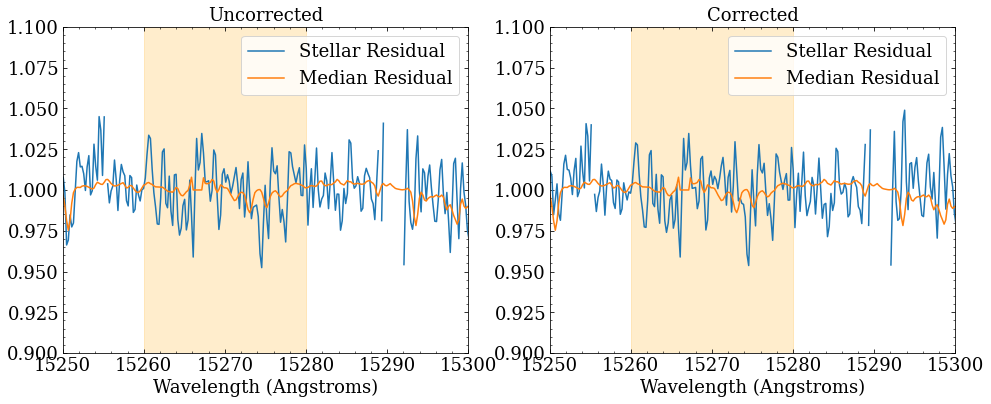

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


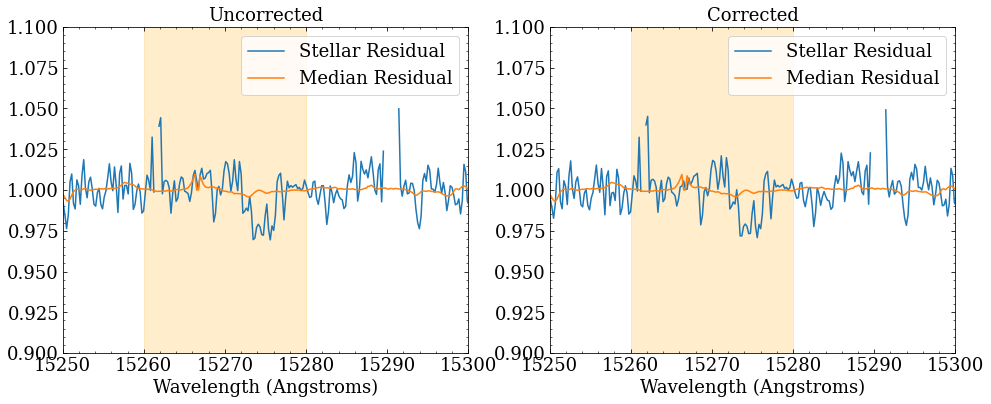

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


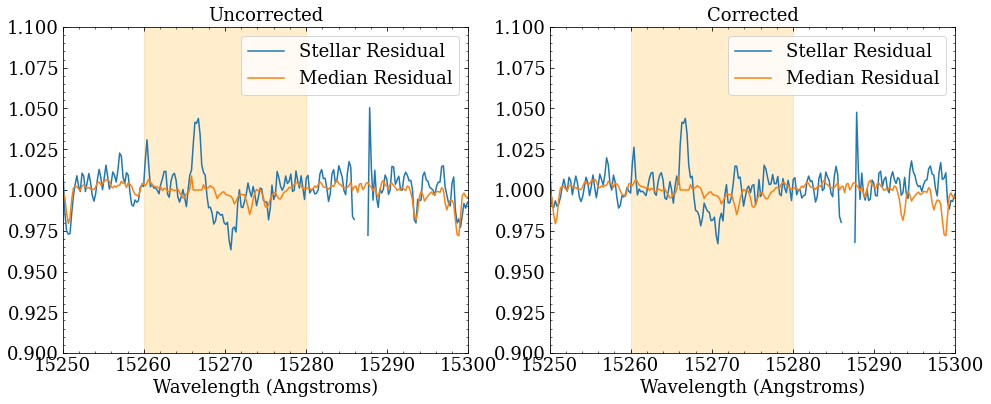

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


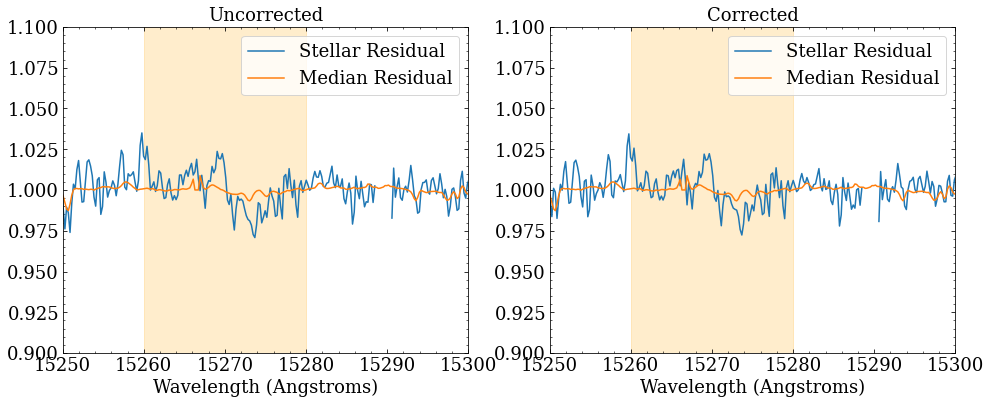

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


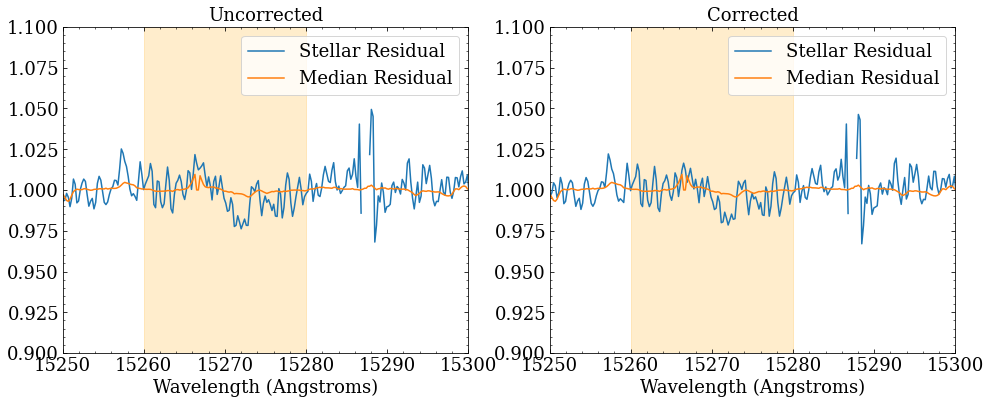

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


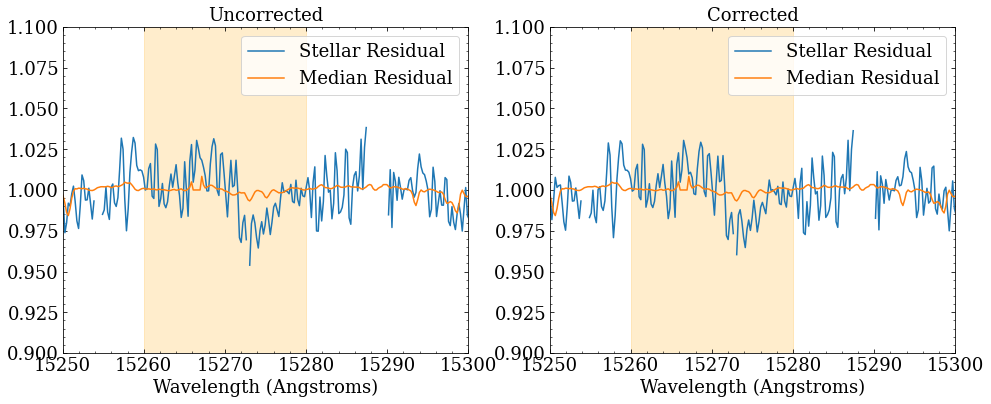

In [38]:
threshold = 0.05
for i in range(10):
    star_row = CA_clean[i]
    star = fits.open(getspecpath(star_row))
    spec, model = (star[1].data, star[3].data)
    stellar_res = np.divide(spec, model)
    mask = np.abs(stellar_res - np.nanmedian(stellar_res)) > threshold * np.nanmedian(stellar_res)
    stellar_res = ma.array(stellar_res, mask = mask)





    medres = get_residual(star_row['TEFF'], star_row['LOGG'], star_row['M_H']).data
    res = medres[0, :]
    res[res - np.nanmedian(res) > 0.01] = 1
    mask = np.abs(res - np.nanmedian(res)) > threshold * np.nanmedian(res)
    res = ma.array(res, mask = mask)



    wavs = getwavs()

    fig, axs = plt.subplots(nrows = 1, ncols =2, figsize = (16,6))
    axs[0].plot(wavs, stellar_res, label = 'Stellar Residual')
#     axs[0].set_xlim(15250, 15500)
    axs[0].set_xlim(15250, 15300)
    axs[0].set_ylim(0.9, 1.1)
    axs[0].set_xlabel('Wavelength (Angstroms)')
    axs[0].plot(wavs, res, label = 'Median Residual')
    axs[0].legend()


    
    axs[1].plot(wavs, stellar_res / res, label = 'Stellar Residual')
    axs[1].set_xlim()
#     axs[1].set_xlim(15250, 15500)
    axs[1].set_xlim(15250, 15300)
    axs[1].set_ylim(0.9, 1.1)
    axs[1].set_xlabel('Wavelength (Angstroms)')
    axs[1].plot(wavs, res, label = 'Median Residual')
    axs[1].legend()
    
    half_dib_highlight = 10
    axs[0].fill_between([15270 - half_dib_highlight, 15270 + half_dib_highlight], [1.2, 1.2], [0, 0], color = 'orange', alpha = 0.2)
    axs[1].fill_between([15270 - half_dib_highlight, 15270 + half_dib_highlight], [1.2, 1.2], [0, 0], color = 'orange', alpha = 0.2)
    
    axs[0].set_title('Uncorrected')
    axs[1].set_title('Corrected')

    
    plt.show()



In [41]:
CA_clean

APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,APOGEE2_TARGET4,TARGFLAGS,SURVEY,PROGRAMNAME,NVISITS,SNR,SNREV,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CHI2,RV_CCFWHM,RV_AUTOFWHM,RV_FLAG,N_COMPONENTS,MEANFIB,SIGFIB,MIN_H,MAX_H,MIN_JK,MAX_JK,GAIAEDR3_SOURCE_ID,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PHOT_G_MEAN_MAG,GAIAEDR3_PHOT_BP_MEAN_MAG,GAIAEDR3_PHOT_RP_MEAN_MAG,GAIAEDR3_DR2_RADIAL_VELOCITY,GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR,GAIAEDR3_R_MED_GEO,GAIAEDR3_R_LO_GEO,GAIAEDR3_R_HI_GEO,GAIAEDR3_R_MED_PHOTOGEO,GAIAEDR3_R_LO_PHOTOGEO,GAIAEDR3_R_HI_PHOTOGEO,ASPCAP_GRID,ASPCAP_CHI2,PARAMFLAG [9],ASPCAPFLAG,ASPCAPFLAGS,FRAC_BADPIX,FRAC_LOWSNR,FRAC_SIGSKY,X_H [27],X_H_ERR [27],X_M [27],X_M_ERR [27],ELEM_CHI2 [27],ELEMFRAC [27],EXTRATARG,MEMBERFLAG,MEMBER,X_H_SPEC [27],X_M_SPEC [27],TEFF,TEFF_ERR,LOGG,LOGG_ERR,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,VMICRO,VMACRO,VSINI,TEFF_SPEC,LOGG_SPEC,C_FE,C_FE_SPEC,C_FE_ERR,C_FE_FLAG,CI_FE,CI_FE_SPEC,CI_FE_ERR,CI_FE_FLAG,N_FE,N_FE_SPEC,N_FE_ERR,N_FE_FLAG,O_FE,O_FE_SPEC,O_FE_ERR,O_FE_FLAG,NA_FE,NA_FE_SPEC,NA_FE_ERR,NA_FE_FLAG,MG_FE,MG_FE_SPEC,MG_FE_ERR,MG_FE_FLAG,AL_FE,AL_FE_SPEC,AL_FE_ERR,AL_FE_FLAG,SI_FE,SI_FE_SPEC,SI_FE_ERR,SI_FE_FLAG,P_FE,P_FE_SPEC,P_FE_ERR,P_FE_FLAG,S_FE,S_FE_SPEC,S_FE_ERR,S_FE_FLAG,K_FE,K_FE_SPEC,K_FE_ERR,K_FE_FLAG,CA_FE,CA_FE_SPEC,CA_FE_ERR,CA_FE_FLAG,TI_FE,TI_FE_SPEC,TI_FE_ERR,TI_FE_FLAG,TIII_FE,TIII_FE_SPEC,TIII_FE_ERR,TIII_FE_FLAG,V_FE,V_FE_SPEC,V_FE_ERR,V_FE_FLAG,CR_FE,CR_FE_SPEC,CR_FE_ERR,CR_FE_FLAG,MN_FE,MN_FE_SPEC,MN_FE_ERR,MN_FE_FLAG,FE_H,FE_H_SPEC,FE_H_ERR,FE_H_FLAG,CO_FE,CO_FE_SPEC,CO_FE_ERR,CO_FE_FLAG,NI_FE,NI_FE_SPEC,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG
bytes30,bytes6,bytes20,bytes30,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,bytes32,float32,float32,int32,int32,int32,int32,int32,int32,bytes132,bytes32,bytes32,int32,float32,float32,int64,bytes132,int64,bytes132,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,int64,int64,bytes256,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32
2M04063599+3531431,apo25m,CA_162-11_btx,none,61.649991,35.528664,161.72526279006618,-12.251131230980798,11.366,0.022,11.086,0.03,11.0,0.02,0.07252261,RJCE_WISE,0.07252261,0.3256324,0,0,0,-2147483646,0,0,APOGEE2_CCLOUD_AS4,apogee2-manga,as4_btx,1,118.38362,118.67717,0,,0,,23.565107,0.0,0.037380762,6167.5757,4.543069,-0.22577177,0.0,0.0,3.042645,21.429415,18.112465,0,1,213.0,0.0,-9999.99,9999.99,-9999.99,9999.99,219166683557038592,2.393143,0.0140943,-4.416,0.0158651,-18.412247,0.0103415,12.6767,13.0943,12.089,24.1771,0.923591,413.01935,411.00797,415.3062,413.5

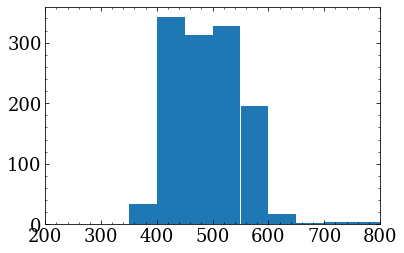

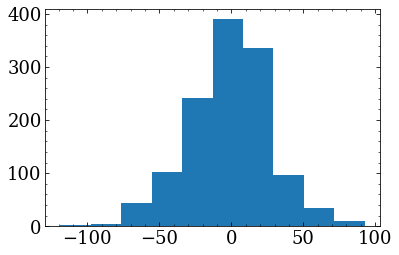

In [81]:
plt.hist(1000/CA_clean['GAIAEDR3_PARALLAX'], bins = np.arange(0,1000, 50))
plt.xlim(200, 800)

plt.show()

plt.hist(CA_clean['VHELIO_AVG'])
plt.show()

In [206]:
plx = CA_clean['GAIAEDR3_PARALLAX'].data
rv = CA_clean['VHELIO_AVG'].data

# np.random.seed(0)
# near =CA_clean[np.random.choice(np.where((1000/plx > 300) & (1000/plx < 400))[0])]
# np.random.seed(0)
# far = CA_clean[np.random.choice(np.where((1000/plx > 550) & (1000/plx < 700))[0])]

# np.random.seed(0)
# vtoward = CA_clean[np.random.choice(np.where(rv < -50)[0])]
# np.random.seed(0)
# vzero = CA_clean[np.random.choice(np.where(np.abs(rv) < 10)[0])]
# np.random.seed(3)
# vaway = CA_clean[np.random.choice(np.where(rv > 50)[0])]



near = CA_clean[(1000/plx > 300) & (1000/plx < 400)][0]
far = CA_clean[(1000/plx > 550) & (1000/plx < 700) & (CA_clean['TEFF'] < 5000) & (CA_clean['LOGG'] < 3.5)][1]#18
# this is a red giant at a relatively far distance

vtoward = CA_clean[rv < -50][0]
vzero = CA_clean[np.abs(rv) < 10][9]
vaway = CA_clean[(rv > 50)][4]

selected = vstack([near, far, vtoward, vzero, vaway])

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


In [278]:
3e5*(15278 / 15272.42-1)


109.60934809283174

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


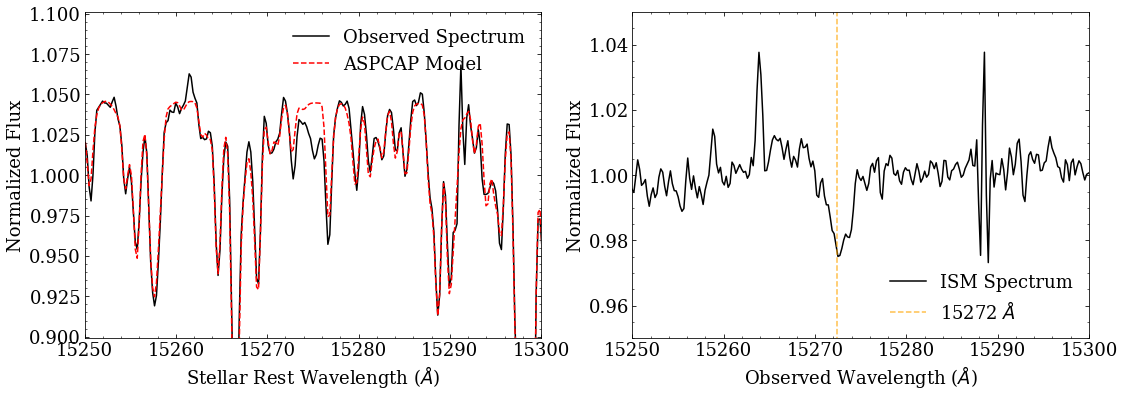

In [302]:
# wavshift = lambda wavs, rv : wavs / (1 -rv / 3e5)
wavshift = lambda wavs, rv : wavs *  ( 1 + rv / 3e5)
wavs_rv = wavshift(wavs, far['VHELIO_AVG'])

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))

star = fits.open(getspecpath(far))
spec, model = (star[1].data, star[3].data)
stellar_res = np.divide(spec, model)
mask = np.abs(stellar_res - np.nanmedian(stellar_res)) > threshold * np.nanmedian(stellar_res)
stellar_res = ma.array(stellar_res, mask = mask)



medres = get_residual(far['TEFF'], far['LOGG'], far['M_H']).data
res = medres[0, :]
res[res - np.nanmedian(res) > 0.01] = 1
mask = np.abs(res - np.nanmedian(res)) > threshold * np.nanmedian(res)
res = ma.array(res, mask = mask)


axs[0].plot()

# axs[0].set_title('Observed Spectrum + ASPCAP')
axs[0].plot(wavs, spec, label = 'Observed Spectrum', c= 'k')
axs[0].plot(wavs, model, label = 'ASPCAP Model', c = 'r', linestyle = 'dashed')
axs[0].set_xlim(xmin, xmax)
axs[0].set_ylim(0.899, 1.101)
axs[0].legend(frameon=False)


# axs[1].set_title('Interstellar Spectrum')
axs[1].plot(wavs_rv, stellar_res / res, label = 'ISM Spectrum', c= 'k')
# axs[1].plot(wavs, stellar_res / res, label = 'Rest  Wavelength')


# axs[1].plot(wavs, stellar_res, label = 'Uncorrected')
axs[1].set_xlim()
axs[1].set_xlim(xmin, xmax)
axs[1].set_ylim(0.95, 1.05)
axs[1].legend()

axs[0].set_xlabel('Stellar Rest Wavelength ($\AA$)')
axs[0].set_ylabel('Normalized Flux')
axs[1].set_xlabel(r'Observed Wavelength ($\AA$)')
axs[1].set_ylabel('Normalized Flux')
#     axs[1].legend()

# Highlight DIB location
half_dib_highlight = 5
DIBposition = 15272.42
# axs[0].plot([15270, 15270], [ymin, ymax], color = 'orange', linestyle = 'dashed', alpha = 0.7)
axs[1].plot([DIBposition, DIBposition], [ymin, ymax], color = 'orange', linestyle = 'dashed', alpha = 0.7, label = '15272 $\AA$')
axs[1].legend(frameon=False)

plt.savefig('ISMspectrum.jpg', transparent = False)

plt.show()

In [284]:
print(wavshift(15270, far['VHELIO_AVG']))
print(15270  / (1 + far['VHELIO_AVG']/3e5))

print(far['VHELIO_AVG'])

15267.33916675923
15272.661760876896
-52.284813


In [239]:
print(wavs)
print(wavs_rv)
print(far['VHELIO_AVG'])

[15100.80154164 15101.01016837 15101.21879797 ... 16999.33764338
 16999.57249953 16999.80735892]
[15098.17019163 15098.378782   15098.58737525 ... 16996.375469
 16996.61028423 16996.8451027 ]
-52.284813


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python

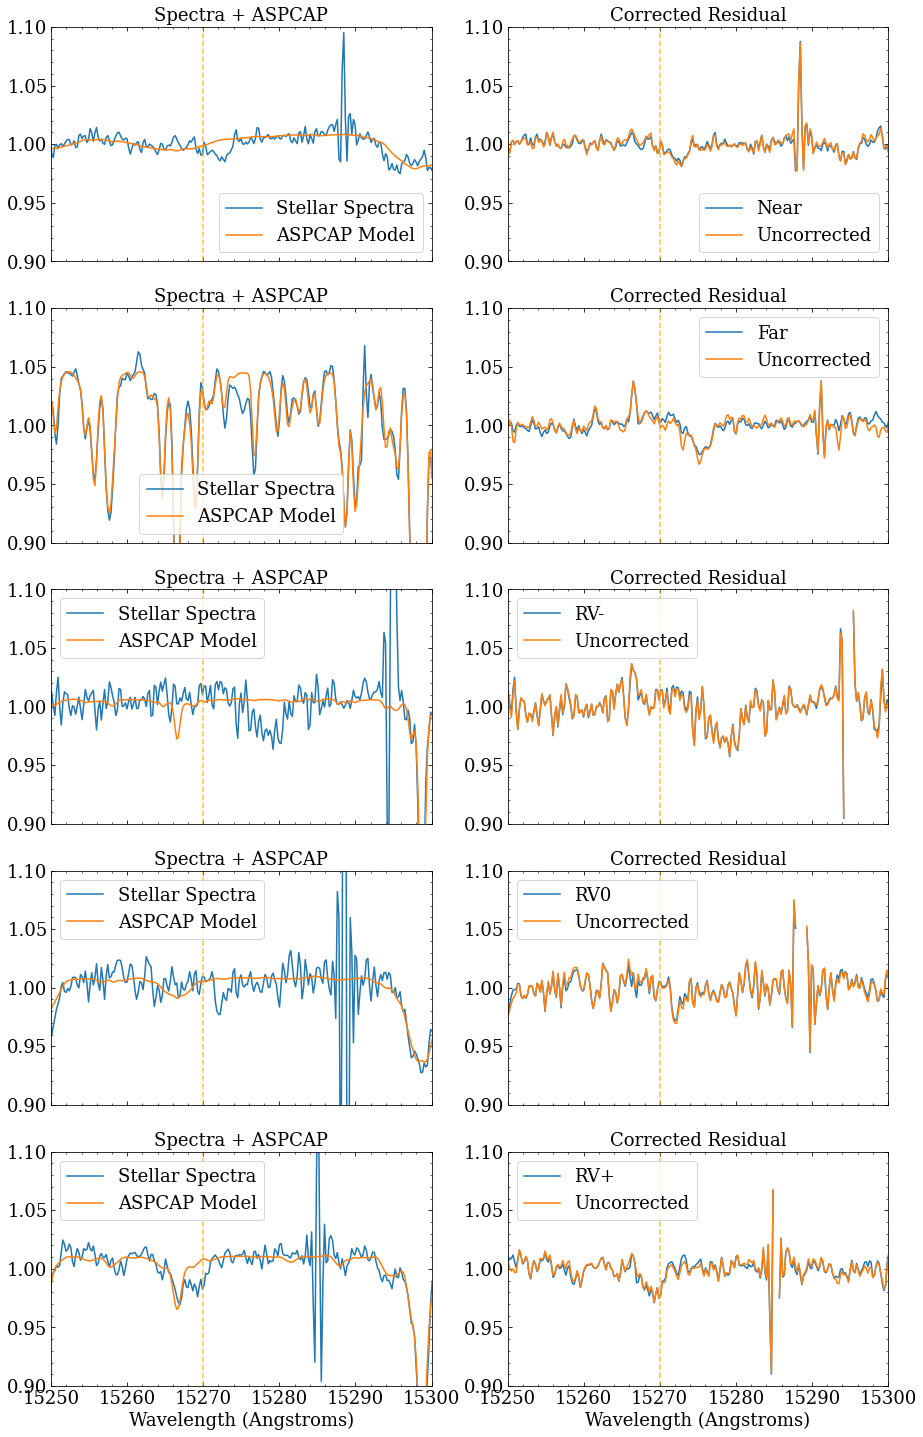

In [281]:
threshold = 0.1 # for masking
xmin, xmax = (15250, 15300)
ymin, ymax = (0.9, 1.1)
wavs = getwavs()
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (15,25), sharex = True)



titles = ['Near', 'Far', 'RV-', 'RV0', 'RV+']
for i in range(len(selected)):
    star_row = selected[i]
    title = titles[i]
    axs = axes[i, :]
    
    star = fits.open(getspecpath(star_row))
    spec, model = (star[1].data, star[3].data)
    stellar_res = np.divide(spec, model)
    mask = np.abs(stellar_res - np.nanmedian(stellar_res)) > threshold * np.nanmedian(stellar_res)
    stellar_res = ma.array(stellar_res, mask = mask)


    medres = get_residual(star_row['TEFF'], star_row['LOGG'], star_row['M_H']).data
    res = medres[0, :]
    res[res - np.nanmedian(res) > 0.01] = 1
    mask = np.abs(res - np.nanmedian(res)) > threshold * np.nanmedian(res)
    res = ma.array(res, mask = mask)


#     fig, axs = plt.subplots(nrows = 1, ncols =2, figsize = (16,6))
    
    axs[0].set_title('Spectra + ASPCAP')
    axs[0].plot(wavs, spec, label = 'Stellar Spectra')
    axs[0].plot(wavs, model, label = 'ASPCAP Model')
    axs[0].set_xlim(xmin, xmax)
    axs[0].set_ylim(ymin, ymax)
    axs[0].legend()


    axs[1].set_title('Corrected Residual')
    axs[1].plot(wavs, stellar_res / res, label = title)
    axs[1].plot(wavs, stellar_res, label = 'Uncorrected')
    axs[1].set_xlim()
    axs[1].set_xlim(xmin, xmax)
    axs[1].set_ylim(ymin, ymax)
    axs[1].legend()
    
    if i == 4:
        axs[0].set_xlabel('Wavelength (Angstroms)')
        axs[1].set_xlabel('Wavelength (Angstroms)')
#     axs[1].legend()
    
    # Highlight DIB location
    half_dib_highlight = 5
#     axs[0].fill_between([15270 - half_dib_highlight, 15270 + half_dib_highlight], 
#                         [1.2, 1.2], [0, 0], color = 'orange', alpha = 0.2)
#     axs[1].fill_between([15270 - half_dib_highlight, 15270 + half_dib_highlight], 
#                         [1.2, 1.2], [0, 0], color = 'orange', alpha = 0.2)
    axs[0].plot([15270, 15270], [ymin, ymax], color = 'orange', linestyle = 'dashed', alpha = 0.7)
    axs[1].plot([15270, 15270], [ymin, ymax], color = 'orange', linestyle = 'dashed', alpha = 0.7)


    
#     fig.suptitle(title)

    
#     plt.show()
plt.show()

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


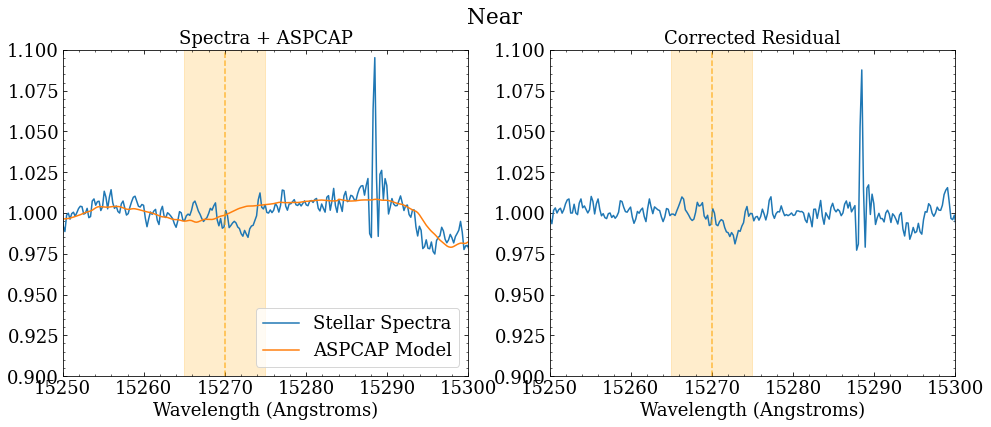

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


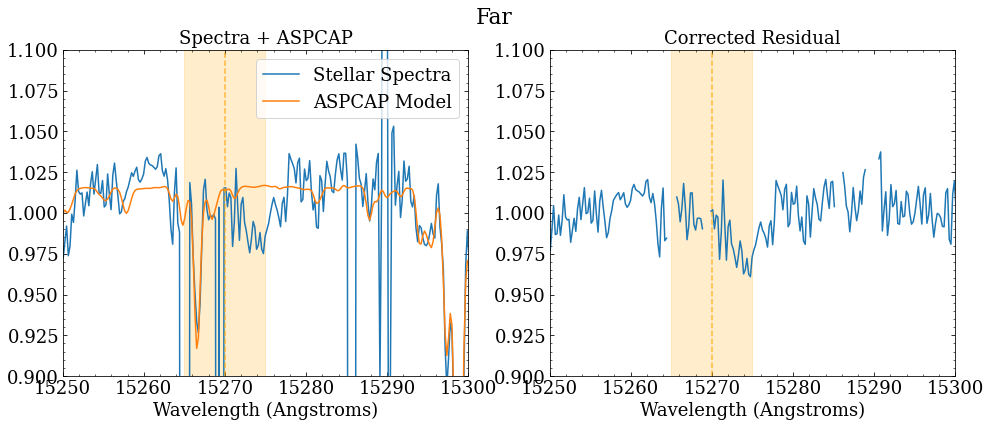

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


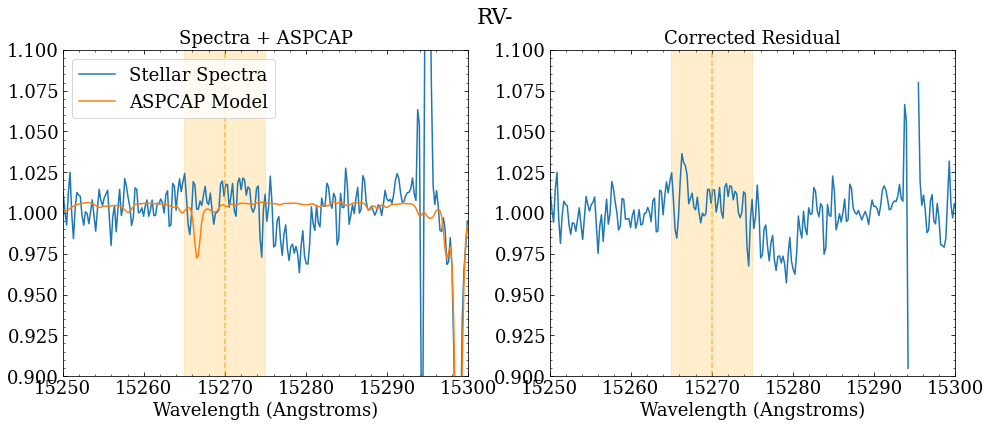

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


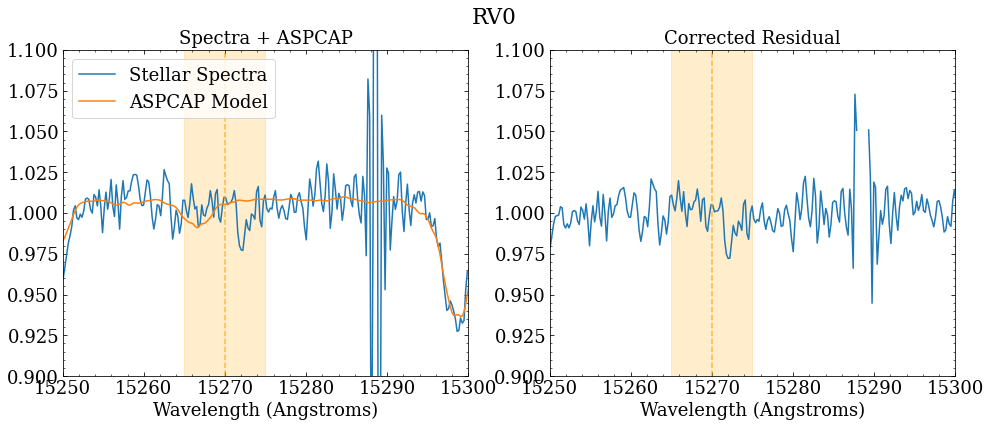

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


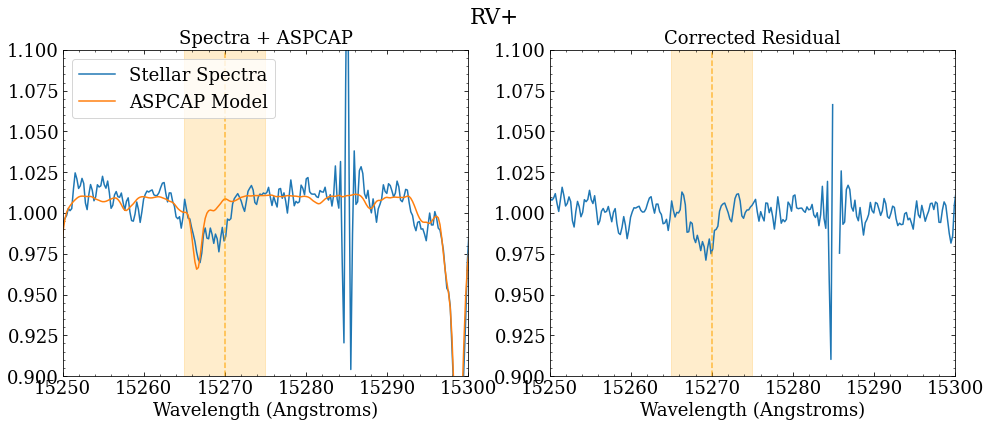

In [189]:
threshold = 0.1 # for masking
xmin, xmax = (15250, 15300)
ymin, ymax = (0.9, 1.1)
wavs = getwavs()


titles = ['Near', 'Far', 'RV-', 'RV0', 'RV+']
for i in range(len(selected)):
    star_row = selected[i]
    title = titles[i]
    
    star = fits.open(getspecpath(star_row))
    spec, model = (star[1].data, star[3].data)
    stellar_res = np.divide(spec, model)
    mask = np.abs(stellar_res - np.nanmedian(stellar_res)) > threshold * np.nanmedian(stellar_res)
    stellar_res = ma.array(stellar_res, mask = mask)


    medres = get_residual(star_row['TEFF'], star_row['LOGG'], star_row['M_H']).data
    res = medres[0, :]
    res[res - np.nanmedian(res) > 0.01] = 1
    mask = np.abs(res - np.nanmedian(res)) > threshold * np.nanmedian(res)
    res = ma.array(res, mask = mask)


    fig, axs = plt.subplots(nrows = 1, ncols =2, figsize = (16,6))
    
    axs[0].set_title('Spectra + ASPCAP')
    axs[0].plot(wavs, spec, label = 'Stellar Spectra')
    axs[0].plot(wavs, model, label = 'ASPCAP Model')
    axs[0].set_xlim(xmin, xmax)
    axs[0].set_ylim(ymin, ymax)
    axs[0].set_xlabel('Wavelength (Angstroms)')
    axs[0].legend()


    axs[1].set_title('Corrected Residual')
    axs[1].plot(wavs, stellar_res / res, label = 'Stellar Residual')
#     axs[1].plot(wavs, res, label = 'Median Residual')
    axs[1].set_xlim()
    axs[1].set_xlim(xmin, xmax)
    axs[1].set_ylim(ymin, ymax)
    axs[1].set_xlabel('Wavelength (Angstroms)')
#     axs[1].legend()
    
    # Highlight DIB location
    half_dib_highlight = 5
    axs[0].fill_between([15270 - half_dib_highlight, 15270 + half_dib_highlight], 
                        [1.2, 1.2], [0, 0], color = 'orange', alpha = 0.2)
    axs[1].fill_between([15270 - half_dib_highlight, 15270 + half_dib_highlight], 
                        [1.2, 1.2], [0, 0], color = 'orange', alpha = 0.2)
    axs[0].plot([15270, 15270], [ymin, ymax], color = 'orange', linestyle = 'dashed', alpha = 0.7)
    axs[1].plot([15270, 15270], [ymin, ymax], color = 'orange', linestyle = 'dashed', alpha = 0.7)


    
    fig.suptitle(title)

    
    plt.show()



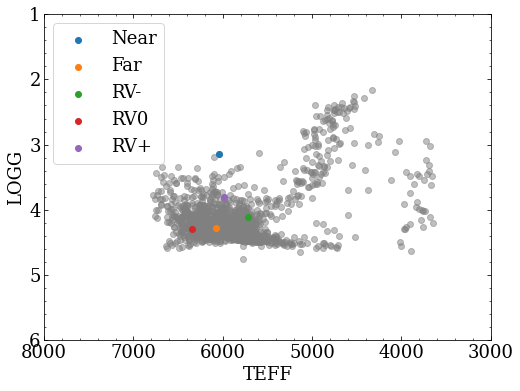

In [190]:
fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(CA_clean['TEFF'], CA_clean['LOGG'], color = 'grey', alpha = 0.5)
for i in range(len(selected)):
    star_row = selected[i]
    ax.scatter(star_row['TEFF'], star_row['LOGG'], label= titles[i])
ax.set_xlim(8000, 3000)
ax.set_ylim(6,1)
ax.set_xlabel('TEFF')
ax.set_ylabel('LOGG')
ax.legend()
plt.show()